In [1]:
%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

# function definitions

In [2]:
def read_pfgse_results(csvfile):
    results = {}
    df = pd.read_csv(csvfile)
    results['Time'] = df.Time.values
    results['Dsat'] = df.Dsat.values
    results['DmsdX'] = df.DmsdX.values
    results['DmsdY'] = df.DmsdY.values
    results['DmsdZ'] = df.DmsdZ.values
    results['Dmsd'] = df.Dmsd.values
    return results

def read_pfgse_params(paramsfile):
    params = {}
    with open(paramsfile) as f:
        lines = f.readlines()
        for line in lines:
            l = line.strip()
            if(len(l.split(': ')) == 2):
                params[l.split(': ')[0]] = l.split(': ')[1]
    return params

def read_pfgse_echoes(echoes_dir):
    echoes = [os.path.join(echoes_dir, ef) for ef in os.listdir(echoes_dir) if 'echoes_' in ef]
    e_order = []
    for i,e in enumerate(echoes):
        idx = int(e.split('_')[-1].split('.')[0])
        e_order.append(idx)
    echoes_files = [x for _,x in sorted(zip(e_order,echoes))]
    echoes = []
    for ef in echoes_files:
        ndict = {}
        df = pd.read_csv(ef)
        ndict['signal'] = df['NMR_signal(mean)'].values
        ndict['noise'] = df['NMR_signal(noise)'].values
        ndict['lhs'] = df['SAT_lhs(mean)'].values
        ndict['rhs'] = df['SAT_rhs'].values
        echoes.append(ndict)
    return echoes
    
    
def read_pfgse_gradients(grads_file):
    grads = {}
    df = pd.read_csv(grads_file)
    grads['Gx'] = df.Gx.values
    grads['Gy'] = df.Gy.values
    grads['Gz'] = df.Gz.values
    grads['Kx'] = df.Kx.values
    grads['Ky'] = df.Ky.values
    grads['Kz'] = df.Kz.values
    return grads    

def read_pfgse_from_dir(datadir):
    data = {}
    params = read_pfgse_params(os.path.join(datadir, 'PFGSE_parameters.txt'))
    results = read_pfgse_results(os.path.join(datadir, 'PFGSE_results.csv'))
    grads = read_pfgse_gradients(os.path.join(datadir, 'PFGSE_gradient.csv'))
    echoes = read_pfgse_echoes(os.path.join(datadir, 'timesamples'))
    
    for i,e in enumerate(echoes):
        e['time'] = results['Time'][i]
    
    data['params'] = params
    data['time'] = results['Time']
    data['Dsat'] = results['Dsat']
    data['Dmsd'] = results['Dmsd']
    data['DmsdX'] = results['DmsdX']
    data['DmsdY'] = results['DmsdY']
    data['DmsdZ'] = results['DmsdZ']
    data['Gx'] = grads['Gx']
    data['Gy'] = grads['Gy']
    data['Gz'] = grads['Gz']
    data['Kx'] = grads['Kx']
    data['Ky'] = grads['Ky']
    data['Kz'] = grads['Kz']
    data['echoes'] = echoes
    
    return data

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
restricted_db = 'data/NMR_PFG_rsp4.57_D0=2.5_rho=20.0_w=100k_ws=1_n=0.002_shift=0_bulk=true/NMR_pfgse/'
unrestricted_db = 'data/NMR_PFG_sphere202_D0=0.25_rho=20.0_w=100k_ws=1_n=0.002_shift=0_bulk=true/NMR_pfgse/'

restricted_data = read_pfgse_from_dir(restricted_db)
unrestricted_data = read_pfgse_from_dir(unrestricted_db)

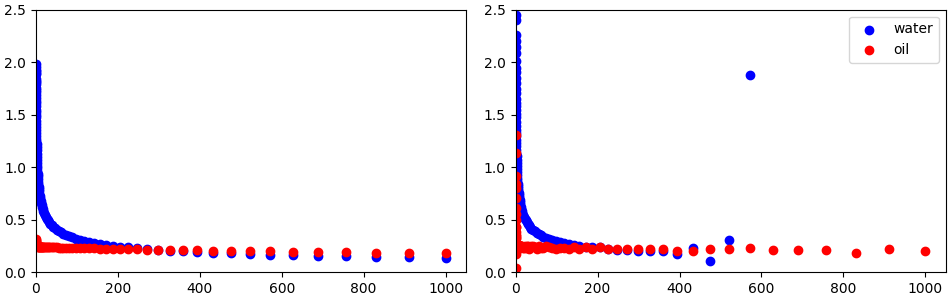

In [4]:
fig,axs = plt.subplots(1,2,figsize=(9.5,3),constrained_layout=True)

axs[0].scatter(restricted_data['time'], restricted_data['Dmsd'], color='b', label='water')
axs[0].scatter(unrestricted_data['time'], unrestricted_data['Dmsd'], color='r', label='oil')
axs[1].scatter(restricted_data['time'], restricted_data['Dsat'], color='b', label='water')
axs[1].scatter(unrestricted_data['time'], unrestricted_data['Dsat'], color='r', label='oil')

for ax in axs:
    ax.set_ylim([0,2.5])
    ax.set_xlim([0, 1.05*max(restricted_data['time'].max(), unrestricted_data['time'].max())])
    
axs[1].legend(loc='best')

In [5]:
plt.close('all')

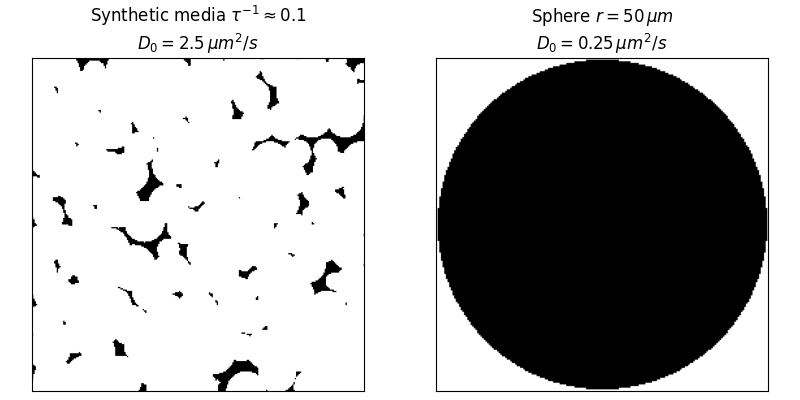

In [6]:
try:
    plt.close(fig)
except:
    pass

fig, axs = plt.subplots(1,2,figsize=(8,4),constrained_layout=True)

synthetic_imfile = "figs/synthetic.png"
sphere_imfile = "figs/sphere.png"

synthetic_img = plt.imread(synthetic_imfile)
axs[0].imshow(synthetic_img, cmap='gray')
axs[0].set_title(r'Synthetic media $\tau^{-1} \approx 0.1$' + '\n' +  '$D_0 = 2.5 \,\mu m^{2}/s$')

sphere_img = plt.imread(sphere_imfile)
img = rgb2gray(sphere_img)
axs[1].imshow(img, cmap="gray")
axs[1].set_title(r"Sphere $r=50 \,\mu m$" + '\n' + r'$D_0 = 0.25\,\mu m^{2}/s$')


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

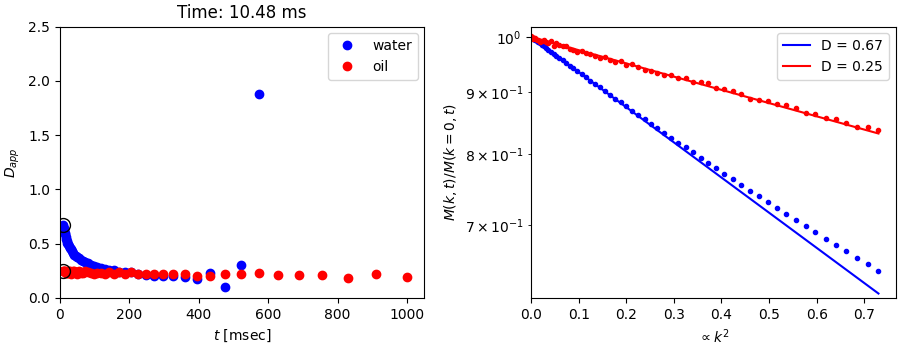

In [7]:
# If fig was created, replace it 
try:
   plt.close(fig2)
except:
    pass

output2 = widgets.Output()
 
with output2:
    fig2, axs2 = plt.subplots(1,2, figsize=(9.0,3.5), constrained_layout=True)

fig2.canvas.toolbar_position = 'bottom'    
start = 50
curr_idx = start
stride = 4
ntimes = restricted_data['time'].size
                   
xdata1 = -restricted_data['echoes'][curr_idx]['rhs'][::stride]
ydata1 = restricted_data['echoes'][curr_idx]['signal'][::stride]/restricted_data['echoes'][curr_idx]['signal'][0]
dline1, = axs2[1].semilogy(xdata1,ydata1,linestyle='none',marker='o',color='b',ms=3)
fit1, = axs2[1].plot([xdata1[0],xdata1[-1]],[1,np.exp(-restricted_data['Dsat'][curr_idx]*xdata1[-1])],
                     color='b',label=f"D = {restricted_data['Dsat'][curr_idx]:.2f}")

xdata2 = -unrestricted_data['echoes'][curr_idx]['rhs'][::stride]
ydata2 = unrestricted_data['echoes'][curr_idx]['signal'][::stride]/unrestricted_data['echoes'][curr_idx]['signal'][0]
dline2, = axs2[1].semilogy(xdata2,ydata2,linestyle='none',marker='o',color='r',ms=3)                 
fit2, = axs2[1].plot([xdata2[0],xdata2[-1]],[1,np.exp(-unrestricted_data['Dsat'][curr_idx]*xdata2[-1])],
                     color='r',label=f"D = {unrestricted_data['Dsat'][curr_idx]:.2f}")

points1, = axs2[0].plot(restricted_data['time'][start::], restricted_data['Dsat'][start::],
                        linestyle='none', marker='o', color='b', label='water')
points2, = axs2[0].plot(unrestricted_data['time'][start::], unrestricted_data['Dsat'][start::],
                        linestyle='none', marker='o', color='r', label='oil')
selected, = axs2[0].plot([restricted_data['time'][curr_idx], unrestricted_data['time'][curr_idx]], 
                            [restricted_data['Dsat'][curr_idx], unrestricted_data['Dsat'][curr_idx]], 
                            linestyle='none', marker='o', color='k', fillstyle='none', ms=10)

# axs2[0].set_xlabel(r'$-k^{2}(t-\delta/3)$')
axs2[1].set_xlabel(r'$\propto k^{2}$')
axs2[1].set_ylabel(r'$M(k,t)/M(k=0,t)$')
axs2[1].set_xlim([0,1.05*max(xdata1[-1],xdata2[-1])])
axs2[1].set_ylim([0.95*min(ydata1[-1],ydata2[-1]),1.02*max(ydata1[0],ydata2[0])])
axs2[1].set_yscale('log')
axs2[1].legend(loc='best')

axs2[0].legend(loc='best')
axs2[0].set_title(f"Time: {restricted_data['time'][curr_idx]:.2f} ms")
axs2[0].set_ylabel(r'$D_{app}$')
axs2[0].set_xlabel(r'$t$ [msec]')
axs2[0].set_ylim([0,2.5])
axs2[0].set_xlim([0,1.05*max(restricted_data['time'][-1],unrestricted_data['time'][-1])])

# create some control elements
slider2 = widgets.IntSlider(
    value=0,
    min=0, max=ntimes-1-start, step=1,
    description='$t$',
    continuous_update=False
)
 
# callback function
def update_time(change):
    curr_idx = start + change.new
    xdata1 = -restricted_data['echoes'][curr_idx]['rhs'][::stride]
    ydata1 = restricted_data['echoes'][curr_idx]['signal'][::stride]/restricted_data['echoes'][curr_idx]['signal'][0]
    xdata2 = -unrestricted_data['echoes'][curr_idx]['rhs'][::stride]
    ydata2 = unrestricted_data['echoes'][curr_idx]['signal'][::stride]/unrestricted_data['echoes'][curr_idx]['signal'][0]
    xlims = [0.0, 1.05*max(xdata1[-1],xdata2[-1])]
    ylims = [0.95*min(np.abs(ydata1[-1]),np.abs(ydata2[-1])),1.02]#*max(ydata1[0],ydata2[0])]
    
    dline1.set_xdata(xdata1)
    dline1.set_ydata(ydata1)
    fit1.set_xdata([xdata1[0],xdata1[-1]])
    fit1.set_ydata([1,np.exp(-restricted_data['Dsat'][curr_idx]*xdata1[-1])])
    fit1.set_label(f"D = {restricted_data['Dsat'][curr_idx]:.2f}")
    
    dline2.set_xdata(xdata2)
    dline2.set_ydata(ydata2)
    fit2.set_xdata([xdata2[0],xdata2[-1]])
    fit2.set_ydata([1,np.exp(-unrestricted_data['Dsat'][curr_idx]*xdata2[-1])])
    fit2.set_label(f"D = {unrestricted_data['Dsat'][curr_idx]:.2f}")
    
    selected.set_xdata([restricted_data['time'][curr_idx], unrestricted_data['time'][curr_idx]])
    selected.set_ydata([restricted_data['Dsat'][curr_idx], unrestricted_data['Dsat'][curr_idx]])
    
    axs2[1].set_xlim(xlims)
    axs2[1].set_ylim(ylims)
    axs2[0].set_title(f"Time: {restricted_data['time'][curr_idx]:.2f} ms")
    axs2[1].legend()
#     fig2.canvas.draw()


# connect callbacks and traits
slider2.observe(update_time, 'value')    
grapher2 = widgets.VBox([slider2, output2])
display(grapher2)

In [ ]:
plt.close('all')